<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 2:</span> MODELLING STACKOVERFLOW QUESTIONS TAGS</h1>

In this module, we'll cover:
1. [Import modules and load data](#modules)
2. [Supervised Machine learning models](#supervised)<br>
    2.1. [MultinomialNB](#nb)<br>
    2.2. [LinearSVC](#svc)<br>
    2.3. [Logistic Reg](#log)<br>
    2.3. [Predict tags](#tags_s)<br>

3. [Supervised Machine learning models](#unsupervised)<br>
    3.1. [Clustering KMEANS](#kmeans)<br>
    3.2. [Model training](#train)<br>
    3.3. [Predict tags](#tags_u)<br>
 
4. [Comparison between Supervised and unsupervised Machine learning models](#comparison)
<hr>

<span id="modules"></span>
## 1. Import modules and load data

In [1]:
import pandas as pd
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.mixture import GMM
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joël\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [3]:
tic()
data_df=pd.read_csv('StackOverflow_7.csv')
data_df.head()
tac()

Time passed: 0hour:0min:9sec


In [4]:
data_df.columns

Index(['Unnamed: 0', 'Id', 'CreationDate', 'Score', 'Body', 'Title', 'Tags',
       'Body_whtml', 'Tags_', 'Body_word_count', 'Title_word_count',
       'Tags_word_count', 'Title_body', 'Tags_plus', 'clean_word',
       'Tags_final', '.net', 'actionscript-3', 'ajax', 'algorithm', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa',
       'cocoa-touch', 'css', 'database', 'debugging', 'delphi', 'design',
       'design-patterns', 'django', 'eclipse', 'excel', 'flash', 'flex',
       'html', 'iis', 'internet-explorer', 'iphone', 'java', 'javascript',
       'jquery', 'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'versi

In [5]:
data_df=data_df.head(10000)

In [6]:
df_tags = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body'], axis=1)

In [7]:
df_tags.columns

Index(['.net', 'actionscript-3', 'ajax', 'algorithm', 'apache', 'arrays',
       'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa', 'cocoa-touch',
       'css', 'database', 'debugging', 'delphi', 'design', 'design-patterns',
       'django', 'eclipse', 'excel', 'flash', 'flex', 'html', 'iis',
       'internet-explorer', 'iphone', 'java', 'javascript', 'jquery',
       'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'version-control',
       'visual-studio', 'visual-studio-2008', 'wcf', 'web-services', 'winapi',
       'windows', 'winforms', 'wpf', 'xml'],
      dtype='object')

<span id="supervised"></span>
## 2. Supervised Machine learning models
   2.1. [MultinomialNB](#nb)<br>
   2.2. [LinearSVC](#svc)<br>
   2.3. [Logistic Reg](#log)<br>
   2.3. [Predict tags](#tags_s)

In [13]:
# split the data, leave 1/5 out for testing
tic()
data_x = data_df[['clean_body']]
data_y = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data_x,data_y, test_size=0.2, random_state=42)

x_train_1=x_train.as_matrix()
x_test_1=x_test.as_matrix()

y_train_1=y_train.as_matrix()
y_test_1=y_test.as_matrix()

# transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train_1.tolist()]
test_x = [x[0].strip() for x in x_test_1.tolist()]
tac()

Time passed: 0hour:0min:0sec


<span id="nb"></span>
## 2.1. MultinomialNB

In [32]:
tic()
stop_words = set(stopwords.words("english"))
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters_1 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2),(1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}
grid_search_tune_1 = GridSearchCV(pipeline_1, parameters_1, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_1.fit(train_x, y_train_1)
print (grid_search_tune_1.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_1 = grid_search_tune_1.best_estimator_
predictions_1 = best_clf_1.predict(test_x)

print (classification_report(y_test_1, predictions_1,target_names=df_tags.columns))
tac()

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.6min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True),
          n_jobs=1))]
Applying best classifie

<span id="svc"></span>
## 2.2. LinearSVC

In [33]:
tic()
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC())),
])

parameters_2 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

grid_search_tune_2 = GridSearchCV(pipeline_2, parameters_2, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_2.fit(train_x, y_train_1)
print (grid_search_tune_2.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_2 = grid_search_tune_2.best_estimator_
predictions_2 = best_clf_2.predict(test_x)

print (classification_report(y_test_1, predictions_2,target_names=df_tags.columns))
tac()

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  7.1min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squa

<span id="log"></span>
## 2.3. Logistic Reg

In [34]:
tic()
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
])
parameters_3 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

grid_search_tune_3 = GridSearchCV(pipeline_3, parameters_3, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_3.fit(train_x, y_train_1)
print (grid_search_tune_3.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_3 = grid_search_tune_3.best_estimator_
predictions_3 = best_clf_3.predict(test_x)

print (classification_report(y_test_1, predictions_3,target_names=df_tags.columns))
tac()

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 59.8min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scal

<span id="tags_s"></span>
## 2.3. Predict tags

In [35]:
from sklearn.externals import joblib
joblib.dump(grid_search_tune_2.best_estimator_, 'linearSVC_1.pkl',compress=3)

['linearSVC_1.pkl']

In [39]:
linear_SVC = joblib.load('linearSVC_1.pkl')

In [37]:
most_freq_w=['using','like', 'im', 'would', 'use', 'code', 'get', 'way', 'new', 'want']
less_feq_w=['efdestroyworksheetws', 'jltmatrix0length', 'offltagtltligtthis','postmessagemyprojectentitiesbetmessage',
           'columnsfooter', 'omittednote', 'classestaskm95720090413', 'httpossoetikerchrrdtoo', 'addcontrolstolistccontrols',
           'dofollowuplots']

In [38]:
def clean_p(text):
    text = " ".join(x.lower() for x in text.split() ) 
    text=re.sub('[^\w\s]', "", text)
    text=re.sub(re.escape('?'), "", text)
    stop = stopwords.words('english')
    text = " ".join(x for x in text.split() if x not in stop)
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    return(text)

In [40]:
def predict_SU_(text):
    text=[clean_p(text)]
    predict=linear_SVC.predict(text)
    tags=[]
    for i in range(0,len(df_tags.columns)):
        if predict.tolist()[0][i]==1:
            tags.append(df_tags.columns[i])
    tags_="".join('<'+x+'>' for x in tags)
    return tags_

In [49]:
def predict_SU_S(text):
    text=[clean_p(text)]
    predict=linear_SVC.predict(text)
    tags=[]
    for i in range(0,len(df_tags.columns)):
        if predict.tolist()[0][i]==1:
            tags.append(df_tags.columns[i])
    tags_=" ".join(x for x in tags)
    return tags_

In [43]:
x_test.head()

,clean_body
6252,error serializing string webservice call morni...
4684,database system relational types database syst...
1731,set test cert ssl connection net create ssl co...
4742,killing excelexe server possible duplicate pro...
4521,apache rewrite based subdomain trying redirect...


In [47]:
predict_SU_(x_test['clean_body'][4684])

'<database>'

In [48]:
data_df['Tags'][4684]

'<database>'

In [58]:
y_test_add.head()

,index,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,windows,winforms,wpf,xml,Select_tags,predict_tags_S,tags_count_r,tags_count_s,tags_count_rs,tags_count_rsp
0,6252,0,0,0,0,0,0,0,0,0,...,0,0,0,0,web-services,.net c# string xml,1,4,0,0
1,4684,0,0,0,0,0,0,0,0,0,...,0,0,0,0,database,database,1,1,1,1
2,1731,1,0,0,0,0,0,0,0,0,...,0,0,0,0,.net,.net,1,1,1,1
3,4742,0,0,0,0,0,0,1,0,0,...,0,0,0,0,asp.net excel,asp.net c# excel,2,3,2,1
4,4521,0,0,0,0,1,0,0,0,0,...,0,0,0,0,apache,apache,1,1,1,1


In [60]:
y_test_add['tags_count_rsp'].sum()/y_test_add.shape[0]

0.47

<span id="unsupervised"></span>
## 3. Supervised Machine learning models
   3.1. [Clustering KMEANS](#kmeans)<br>
   3.2. [Model training](#train)<br>
   3.3. [Predict tags](#tags_u)

In [104]:
def clean(text):
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = " ".join(w for w in words if not w in stops)
    return(meaningful_words)

In [78]:
tic()
data_df['clean_word']=data_df['clean_body'].apply(lambda x:clean(str(x)))
tac()

Time passed: 0hour:0min:3sec


In [79]:
data_df['clean_word'].head()

0    convert decimal double trackbar change forms o...
1    percentage width child element absolutely posi...
2    calculate someones age c given datetime repres...
3    calculate relative time c given specific datet...
4    determine users timezone standard web server a...
Name: clean_word, dtype: object

<span id="kmeans"></span>
## 3.1. Clustering KMEANS

In [80]:
tic()
stop_words = set(stopwords.words("english"))
tfidf=TfidfVectorizer(stop_words=stop_words)
X_text=tfidf.fit_transform(data_df['clean_word'])
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=2000)
X_tsvd = tsvd.fit(X_text)
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
# Run function
print("2000 features out of",X_text.shape[1],"has cumulative variance ration egal to",tsvd_var_ratios.sum())
tac()

2000 features out of 65645 has cumulative variance ration egal to 0.6628106034705903
Time passed: 0hour:3min:8sec


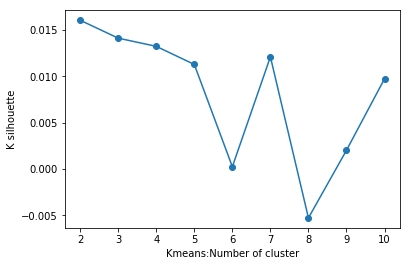

Time passed: 0hour:9min:49sec


In [81]:
tic()
svd = TruncatedSVD(n_components=2000)
X_2d = svd.fit_transform(X_text)

sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(X_2d)
    preds=kmeans.predict(X_2d)
    #print(data["clusters"])
    sse[k] = silhouette_score(X_2d, preds, metric='euclidean') # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'-o')
plt.xlabel("Kmeans:Number of cluster")
plt.ylabel("K silhouette")
plt.show()
tac()

In [83]:
tic()
stop_words = set(stopwords.words("english"))

# components for features reduction
n_components = 2000

# number of clusters we want
n_clusters = 3

# transform matrix of plots into lists to pass to a TfidfVectorizer

tfidf=TfidfVectorizer(stop_words=stop_words)

X_text=tfidf.fit_transform(data_df['clean_word'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())

print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

tac()

   Cluster         0         1         2         3         4         5  \
0        0  0.088368 -0.030836 -0.009701  0.005873 -0.022315  0.035613   
1        0  0.041108 -0.019932 -0.029258  0.016441  0.014666  0.034100   
2        0  0.015823  0.001925 -0.016011 -0.005729 -0.007445 -0.001745   
3        0  0.056109 -0.004902 -0.032879 -0.004051 -0.006312  0.013096   
4        1  0.130578  0.007542  0.007228  0.128007  0.073157  0.003047   

          6         7         8    ...         1990      1991      1992  \
0  0.027815 -0.016145 -0.027215    ...    -0.000612 -0.015661 -0.011079   
1 -0.009423 -0.041918  0.018737    ...    -0.007120  0.004844  0.002251   
2 -0.002725 -0.006288  0.004169    ...     0.011173  0.008315  0.003368   
3 -0.004898 -0.031314  0.011845    ...    -0.011194  0.001306 -0.006013   
4  0.095662  0.048778  0.006756    ...    -0.013309 -0.011655 -0.028107   

       1993      1994      1995      1996      1997      1998      1999  
0  0.002955 -0.016119  0.01158

Time passed: 0hour:0min:2sec


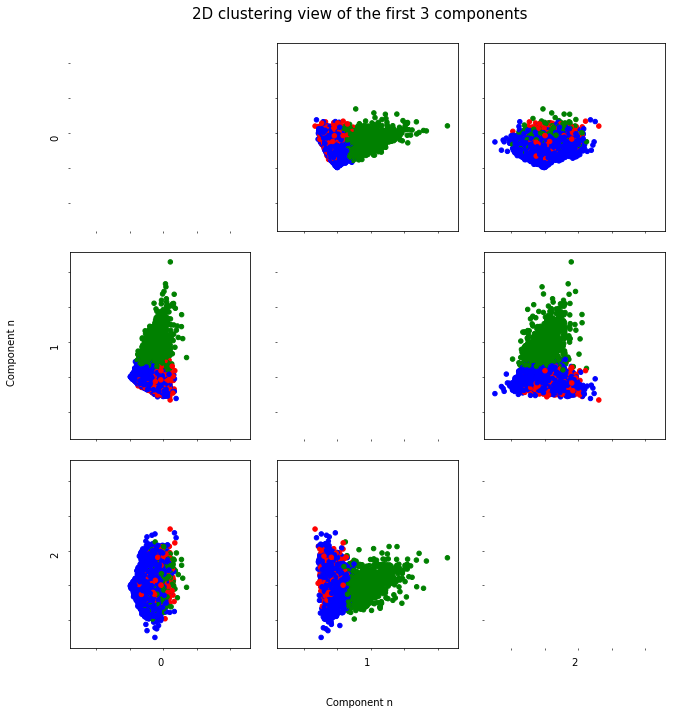

In [84]:
tic()
# make a column for color by clusters
col = df_plot['Cluster'].map({0:'b', 1:'r', 2: 'g'})

# variable for first n dimensions we want to plot
n = 3

# visualize the clusters by first n dimensions (reduced)
fig, ax = plt.subplots(n, n, sharex=True, sharey=True, figsize=(10,10))
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# plot it
k = 0
for i in range(0,n):
    for j in range(0,n):
        if i != j:
            df_plot.plot(kind = 'scatter', x=j, y=i, c=col, ax = ax[i][j], fontsize = 10)
        else:
            ax[i][j].set_xlabel(i)
            ax[i][j].set_ylabel(j)
            ax[i][j].set_frame_on(False)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.suptitle('2D clustering view of the first {} components'.format(n), fontsize = 15)
fig.text(0.5, 0.01, 'Component n', ha='center', fontsize = 10)
fig.text(0.01, 0.5, 'Component n', va='center', rotation='vertical', fontsize = 10)
tac()

In [85]:
tic()
# Logistic Regression approach

data_df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = data_df['clean_word']
    y = data_df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = stop_words)
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d
tac()

Time passed: 0hour:0min:0sec


Time passed: 0hour:0min:4sec


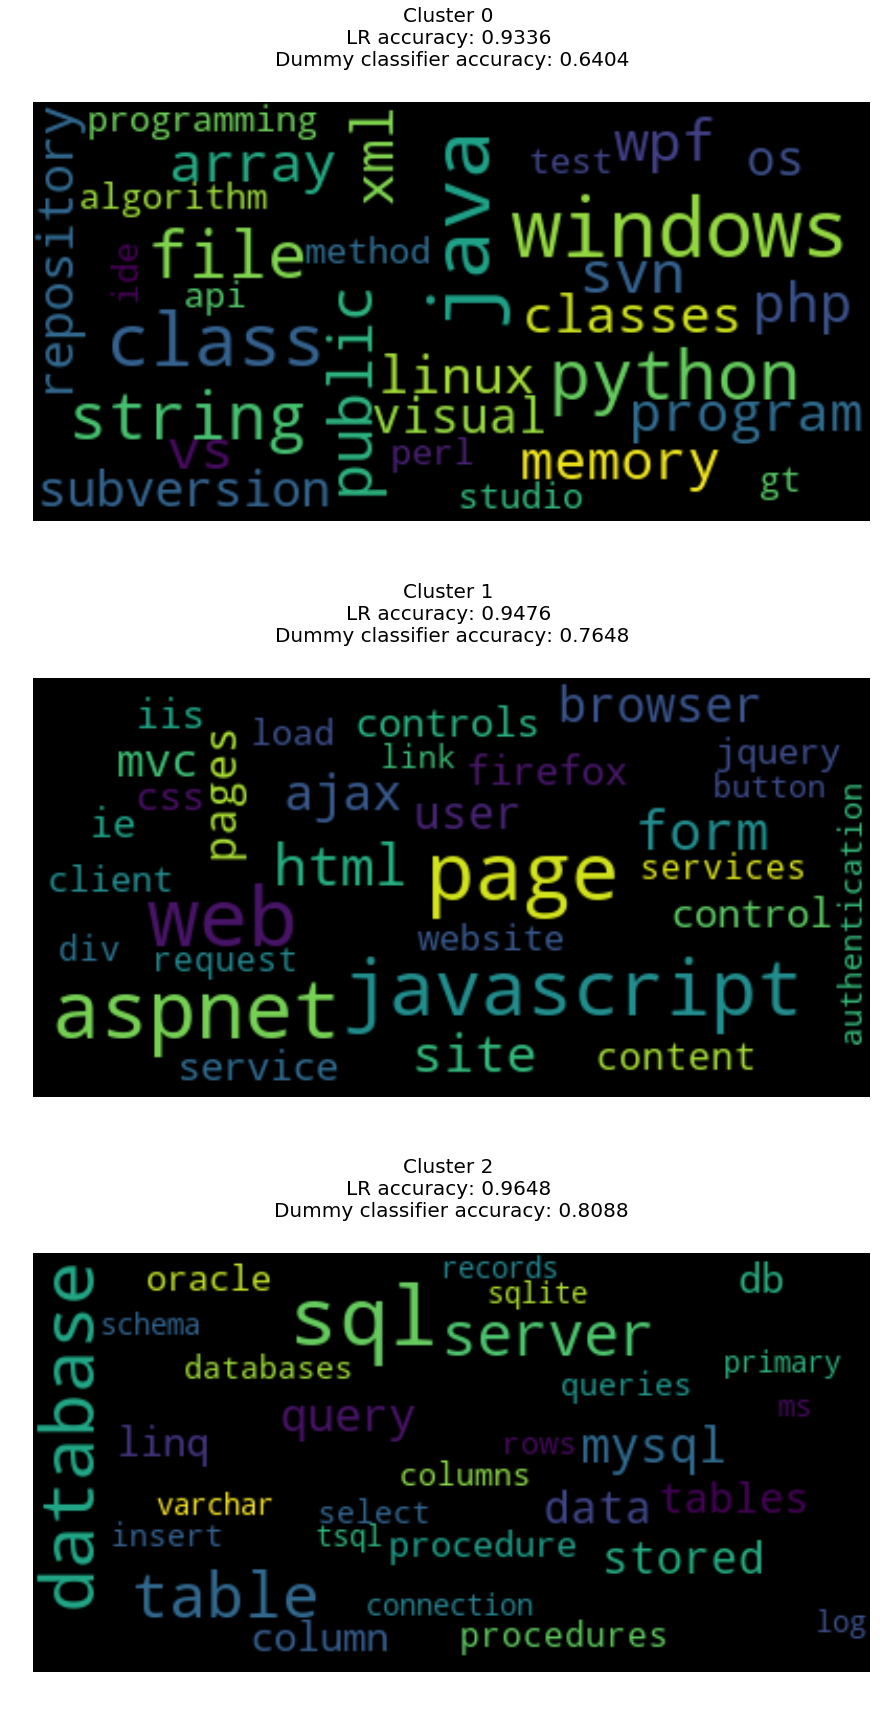

In [86]:
tic()
# visualized it by word clouds
fig, ax = plt.subplots(n_clusters, sharex=True, figsize=(15,10*n_clusters))

for i in range(0, n_clusters):
    d, acc, acc_d = generate_text(i)
    wordcloud = WordCloud(max_font_size=40, collocations=False).fit_words(d)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title('Cluster {} \nLR accuracy: {} \nDummy classifier accuracy: {}'.format(i, acc, acc_d), fontsize = 20)
    ax[i].axis("off")
tac()

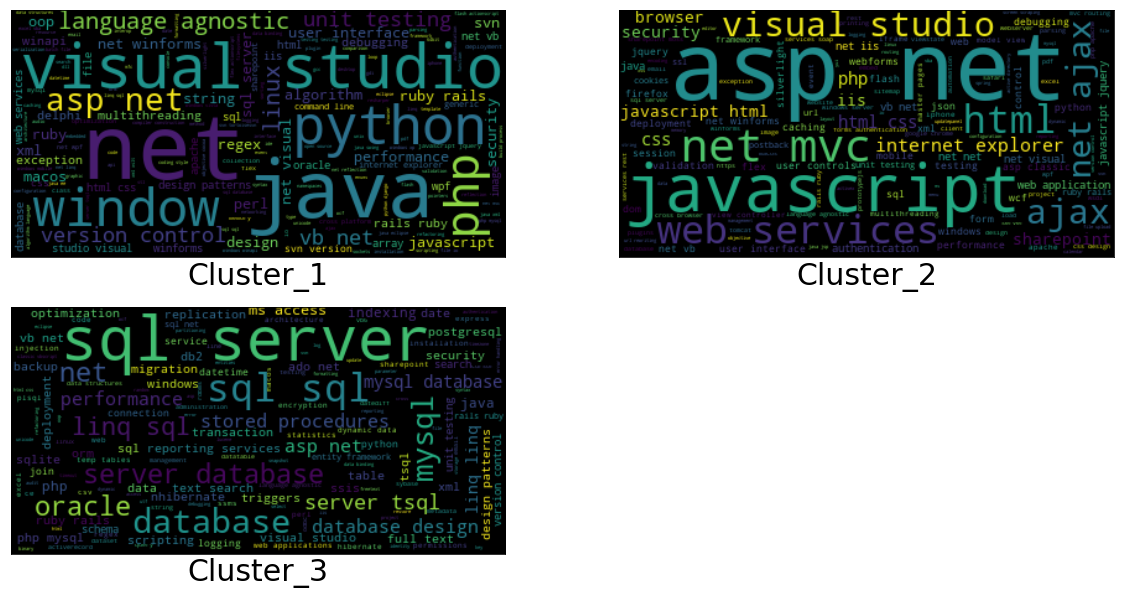

Time passed: 0hour:0min:2sec


In [87]:
tic()
tag_ff=[]
plt.figure(figsize=(20,10))
for i in range(0,3):
    df_tag=data_df[data_df['Cluster']==i]
    text= " ".join(tag_l for tag_l in df_tag.Tags_)
    wordcloud = WordCloud().generate(text)
    tag_ff.append(i)
    i=len(tag_ff)
    plt.subplot(2, 2,i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Cluster_'+str(i),fontsize=30)
plt.show()
tac()

In [66]:
data_df.columns

Index(['Unnamed: 0', 'Id', 'CreationDate', 'Score', 'Body', 'Title', 'Tags',
       'Body_whtml', 'Tags_', 'Body_word_count', 'Title_word_count',
       'Tags_word_count', 'Title_body', 'Tags_plus', 'clean_word',
       'Tags_final', '.net', 'actionscript-3', 'ajax', 'algorithm', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa',
       'cocoa-touch', 'css', 'database', 'debugging', 'delphi', 'design',
       'design-patterns', 'django', 'eclipse', 'excel', 'flash', 'flex',
       'html', 'iis', 'internet-explorer', 'iphone', 'java', 'javascript',
       'jquery', 'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'versi

<span id="train"></span>
## 3.2. Model training

In [91]:
Y_TEST=data_df.iloc[y_test_add['index'].tolist()]['Cluster']
y_train_add=y_train.reset_index()
Y_TRAIN=data_df.iloc[y_train_add['index'].tolist()]['Cluster']

x_test_add=x_test.reset_index()
X_TEST=data_df.iloc[x_test_add['index'].tolist()][['clean_word']]
x_train_add=x_train.reset_index()
X_TRAIN=data_df.iloc[x_train_add['index'].tolist()][['clean_word']]

X_TEST_=X_TEST.as_matrix()
Y_TEST_=Y_TEST.as_matrix()
X_TRAIN_=X_TRAIN.as_matrix()
Y_TRAIN_=Y_TRAIN.as_matrix()

TRAIN_X = [x[0].strip() for x in X_TRAIN_.tolist()]
TEST_X = [x[0].strip() for x in X_TEST_.tolist()]

In [92]:
tic()
pipeline_us1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf',LogisticRegression(solver='sag')),
])
parameters_us1 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

grid_search_tune_us1 = GridSearchCV(pipeline_us1, parameters_us1, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_us1.fit(TRAIN_X, Y_TRAIN_)
print (grid_search_tune_us1.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_us1 = grid_search_tune_us1.best_estimator_
predictions_us1 = best_clf_us1.predict(TEST_X)

print (classification_report(Y_TEST_, predictions_us1))

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.1min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
         

In [93]:
pipeline_us2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LinearSVC()),
])

parameters_us2 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

grid_search_tune_us2 = GridSearchCV(pipeline_us2, parameters_us2, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_us2.fit(TRAIN_X, Y_TRAIN_)
print (grid_search_tune_us2.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_us2 = grid_search_tune_us2.best_estimator_
predictions_us2 = best_clf_us2.predict(TEST_X)

print (classification_report(Y_TEST_, predictions_us2))

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.1min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
 

In [94]:
tic()
pipeline_us3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', MultinomialNB(fit_prior=True, class_prior=None)),
])
parameters_us3 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2),(1, 3)],
    'clf__alpha': (1e-2, 1e-3)
}
grid_search_tune_us3 = GridSearchCV(pipeline_us3, parameters_us3, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_us3.fit(TRAIN_X, Y_TRAIN)
print (grid_search_tune_us3.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_us3 = grid_search_tune_us3.best_estimator_
predictions_us3 = best_clf_us3.predict(TEST_X)

print (classification_report(Y_TEST_, predictions_us3))
tac()

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   47.2s finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))]
Applying best classifier on test data:
             precision    recall  f1

<span id="tags_u"></span>
## 3.3. Predict tags

In [95]:
import pickle
with open('logisticUS.pkl', 'wb') as fid:
    pickle.dump(grid_search_tune_us1.best_estimator_, fid,2)

In [96]:
def dote(a):
    a=a.group(0)
    a=re.sub("\.", "dote", a)
    return a

In [109]:
def clean_1(text):
    text=re.sub(r"http\S+", "", text)
    text = re.sub("#", "hash", text)
    text = re.sub("-", "menos", text)
    text = re.sub(r"\.[a-zA-Z0-9]+",dote, text)
    text=re.sub(re.escape('++'), 'plus', text)
    text=re.sub(r'[^\w\s]','',text)
    words = text.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = " ".join(w for w in words if not w in stops)
    return(meaningful_words)

In [ ]:
data_df['Body'][0]

In [98]:
def tag(text):
    text = re.sub("#", "hash", text)
    text = re.sub("-", "menos", text)
    text = re.sub(r"\.[a-zA-Z0-9]+",dote, text)
    text=re.sub(re.escape('++'), 'plus', text) 
    tags = text.lower().split()                                             
    meaningful_tag = " ".join(w for w in tags)
    return(meaningful_tag)

In [99]:
data_df['clean_words_']=data_df['Title_body'].apply(lambda x:clean(str(x)))

In [100]:
data_df['new_tags']=data_df['Tags_'].apply(lambda x:tag(str(x)))

In [101]:
def right(text):
    text=text.replace("hash", "#")
    text=text.replace("menos", "-")
    text=text.replace("plus", "++")
    text=text.replace("dote", ".") 
    text = [w for w in text.split()]
    return(text)

In [102]:
tic()
# LDA to extract tags

no_top_tags = 100
def display_topics(model, feature_names, no_top_tags):
    for topic_idx, topic in enumerate(model.components_):
        Tags=" ".join([feature_names[i] for i in topic.argsort()[:-no_top_tags - 1:-1]])
    return Tags
        
for cluster in range(0,3):

    c = CountVectorizer()
    X_text_c = c.fit_transform(data_df[data_df['Cluster']==cluster]['new_tags'])

    lda = LatentDirichletAllocation(learning_method = 'online', n_components=1, random_state=0).fit(X_text_c)
    X_text_c_feature_names = c.get_feature_names()
    print("*"*40)
    print("Top Tags for cluster_"+str(cluster),':')
    print(right(display_topics(lda, X_text_c_feature_names, no_top_tags)))
    print()
tac()

****************************************
Top Tags for cluster_0 :
['c#', '.net', 'java', 'c++', 'python', 'windows', 'php', 'visual-studio', 'asp.net', 'xml', 'svn', 'linux', 'javascript', 'ruby', 'winforms', 'language-agnostic', 'user-interface', 'unit-testing', 'vb.net', 'version-control', 'algorithm', 'macos', 'performance', 'html', 'ruby-on-rails', 'oop', 'sql', 'database', 'wpf', 'multithreading', 'visual-studio-2008', 'regex', 'security', 'winapi', 'perl', 'css', 'eclipse', 'debugging', 'string', 'sql-server', 'flash', 'flex', 'exception', 'oracle', 'design', 'testing', 'delphi', 'mysql', 'actionscript-3', 'design-patterns', 'apache', 'arrays', 'parsing', 'jquery', '.net-3.5', 'web-services', 'generics', 'wcf', 'linq', 'ide', 'memory', 'sockets', 'sharepoint', 'reflection', 'excel', 'networking', 'unix', 'optimization', 'io', 'mfc', 'visual-studio-2005', 'silverlight', 'collections', 'objective-c', 'cocoa', 'cross-platform', 'compiler-construction', '.net-2.0', 'iis', 'image', 'x

In [122]:
def predict(text):
    text=text.lower()
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    text_=[clean(clean_p(text))]
    predict=best_clf_us1.predict(text_)[0]
    c = CountVectorizer()
    X_text_c = c.fit_transform(data_df[data_df['Cluster']==predict]['new_tags'])
    lda = LatentDirichletAllocation(learning_method = 'online', n_components=1, random_state=0).fit(X_text_c)
    X_text_c_feature_names = c.get_feature_names()
    predict_tag=" ".join(x for x in right(display_topics(lda, X_text_c_feature_names, 1000)) if x in text.split())
    
    if predict_tag=='':
        predict_tag=" ".join(x for x in right(display_topics(lda, X_text_c_feature_names, 1000))[0:5])
                          
    return predict_tag

In [123]:
tic()
print(predict(data_df['Title_body'][100]))
tac()

php variables
Time passed: 0hour:0min:4sec


<span id="comparison"></span>
## 4. Comparison between Supervised and unsupervised Machine learning models

In [30]:
#Map only tags used for the supervised model
tic()
y_test_add=y_test.reset_index()
y_test_add['Select_tags']='Select_tags'
for i in range(0,y_test_add.shape[0]):
    tag=[]
    for tags in df_tags.columns:
        if y_test_add[tags][i]==1:
            tag.append(tags)
    y_test_add['Select_tags'][i]=" ".join(x for x in tag)
tac()

Time passed: 0hour:1min:37sec


In [51]:
#Predict tags on test dataset using supervised models
tic()
x_test_add=x_test.reset_index()
y_test_add['predict_tags_S']="predict"
for i in range(0,x_test_add.shape[0]):
    y_test_add['predict_tags_S'][i]=predict_SU_S(x_test_add['clean_body'][i])
y_test_add.head()
tac()

Time passed: 0hour:1min:50sec


In [53]:
# Count number of tags predicted on the supervised model
y_test_add['tags_count_r'] = y_test_add['Select_tags'].apply(lambda x: len(str(x).split(" "))) #Number of original tags
y_test_add['tags_count_s'] = y_test_add['predict_tags_S'].apply(lambda x: len(str(x).split(" ")))
y_test_add.head()

,index,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,web-services,winapi,windows,winforms,wpf,xml,Select_tags,predict_tags_S,tags_count_r,tags_count_s
0,6252,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,web-services,.net c# string xml,1,4
1,4684,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,database,database,1,1
2,1731,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,.net,.net,1,1
3,4742,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,asp.net excel,asp.net c# excel,2,3
4,4521,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,apache,apache,1,1


In [55]:
#Count the right tags predicted using supervised model
tic()
y_test_add['tags_count_rs']=100
for i in range(0,y_test_add.shape[0]):
    y_test_add['tags_count_rs'][i]=len([x for x in y_test_add['Select_tags'][i].split() if x in y_test_add['predict_tags_S'][i].split()])
tac()

Time passed: 0hour:1min:36sec


In [57]:
#Map the questions with all original tags predicted using supervised model
tic()
y_test_add['tags_count_rsp']=0
for i in range(0,y_test_add.shape[0]):
    if y_test_add['tags_count_rs'][i]==y_test_add['tags_count_r'][i]:
        y_test_add['tags_count_rsp'][i]=1
tac()

Time passed: 0hour:0min:45sec


In [132]:
#Predict tags on test dataset using unsupervised models
tic()
d=data_df.iloc[x_test_add['index'].tolist()][['Title_body']]
d=d.reset_index()
y_test_add['predict_tags_U']="predict_U"
for i in range(0,d.shape[0]):
    y_test_add['predict_tags_U'][i]=predict(d['Title_body'][i])
tac()

Time passed: 1hour:43min:30sec


In [135]:
#Count the right tags predicted using unsupervised model
tic()
y_test_add['tags_count_ru']=100
for i in range(0,y_test_add.shape[0]):
    y_test_add['tags_count_ru'][i]=len([x for x in y_test_add['Select_tags'][i].split() if x in y_test_add['predict_tags_U'][i].split()])
tac()

Time passed: 0hour:1min:48sec


In [138]:
#Map the questions with all original tags predicted using unsupervised model
tic()
y_test_add['tags_count_rup']=0
for i in range(0,y_test_add.shape[0]):
    if y_test_add['tags_count_ru'][i]==y_test_add['tags_count_r'][i]:
        y_test_add['tags_count_rup'][i]=1
tac()

Time passed: 0hour:0min:36sec


In [139]:
y_test_add.head()

,index,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,Select_tags,predict_tags_S,tags_count_r,tags_count_s,tags_count_rs,tags_count_rsp,predict_tags_U,tags_count_u,tags_count_ru,tags_count_rup
0,6252,0,0,0,0,0,0,0,0,0,...,web-services,.net c# string xml,1,4,0,0,xml string exception wcf search text object st...,11,0,0
1,4684,0,0,0,0,0,0,0,0,0,...,database,database,1,1,1,1,database types,2,1,1
2,1731,1,0,0,0,0,0,0,0,0,...,.net,.net,1,1,1,1,ssl tcp connection key,4,0,0
3,4742,0,0,0,0,0,0,1,0,0,...,asp.net excel,asp.net c# excel,2,3,2,1,asp.net c# excel file server-side server,6,2,1
4,4521,0,0,0,0,1,0,0,0,0,...,apache,apache,1,1,1,1,apache redirect,2,1,1


In [155]:
n0=y_test_add.tags_count_r.sum() # Total tags to predict
n1=y_test_add.shape[0] # Total questions to predict tags

s0=y_test_add.tags_count_s.sum() # Total tags predicted using supervised model
s1=y_test_add.tags_count_rs.sum() # Total tags well predicted using supervised model
s2=y_test_add.tags_count_rsp.sum() # Total Questions well predicted (at the exact tags) using supervised model
s3=y_test_add[y_test_add['tags_count_rs']>0].shape[0] #Questions with at least one tag well predicted unsupervised

u0=y_test_add.tags_count_u.sum() # Total tags predicted using unsupervised model
u1=y_test_add.tags_count_ru.sum() # Total tags well predicted using unsupervised model
u2=y_test_add.tags_count_rup.sum() # Total Questions well predicted (at the exact tags) using unsupervised model
u3=y_test_add[y_test_add['tags_count_ru']>0].shape[0] #Questions with at least one tag well predicted unsupervised

tab=pd.DataFrame({'Supervised':[n0,n1,s0,s1,s2,s3,round(s1/n0*100,0),round(s2/n1*100,0),round(s3/n1*100,0)],
                 'Unsupervised':[n0,n1,u0,u1,u2,u3,round(u1/n0*100,0),round(u2/n1*100,0),round(u3/n1*100,0)]},
                index=['Total tags to predict','Total questions','Total tags predicted',
                      'Total tags well predicted','Total Questions well predicted','Total Questions with at least one tag well predicted',
                      '(%)Total tags well predicted','(%)Total Questions well predicted', '(%)Total Questions with at least one tag well predicted'])
tab.Supervised=tab.Supervised.astype(int)
tab.Unsupervised=tab.Unsupervised.astype(int)
tab

,Supervised,Unsupervised
Total tags to predict,3182,3182
Total questions,2000,2000
Total tags predicted,2985,8641
Total tags well predicted,1767,1420
Total Questions well predicted,940,700
Total Questions with at least one tag well predicted,1395,1179
(%)Total tags well predicted,56,45
(%)Total Questions well predicted,47,35
(%)Total Questions with at least one tag well predicted,70,59


In [157]:
data_df['Body'][504]

"<p>I'm just in the process of parsing some text and can't remember what the escape character is for a tab in C#?</p>\r\r\r\n"

In [158]:
data_df['Title'][504]

'Tab Escape Character?'